# 0.0. BUSINESS PROBLEM

## 0.1. Challenge

Find who are most valuable customers to be part of "Insiders" group program. 

## 0.2. Business Questions

1. Who are the customers elegible to participate of Insiders group?
2. How many customers will be part of the group?
3. What are main characteristics of these customers?
4. What is the revenue participation percentaga from Insiders group?
5. What is the expected revenue for the next few months from Insiders group?
6. What conditions a customer must meet to be an Insider?
7. What condisions a customer must meet to be excluded from Insiders group?
8. How to ensure that Insiders group is better than the rest of the customer base?
9. What can Marketing do to increase revenue?

# 1.0. FUNCTIONS & LIBS

## 1.1. Imports

In [1]:
import re
import datetime

import numpy  as np
import pandas as pd

from pandas_profiling    import ProfileReport
from yellowbrick.cluster import KElbowVisualizer

from plotly  import express as px
from sklearn import cluster as C
from sklearn import metrics as M

## 1.2. Helper Functions

# 2.0. DATA DESCRIPTION

## 2.1. Variables

**Invoice Number** - unique identifier of each transaction

**Stock Code Product** - item code

**Description Product** - item name

**Quantity** - quantity of each item from a transaction

**Invoice Date** - transaction day

**Unit Price** - item price

**Customer ID** - unque customer identifier

**Country** - country where customer lives

## 2.2. Load Data

In [2]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='iso-8859-1')
df_raw = df_raw.drop(columns = 'Unnamed: 8')

## 2.3. Rename Columns

In [3]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df_raw.columns = cols_new

## 2.4. DF Dimensions

In [4]:
print('Number of rows: {}'.format(df_raw.shape[0]))
print('Number of columns: {}'.format(df_raw.shape[1]))

Number of rows: 541909
Number of columns: 8


## 2.5. Check NA and Duplicates

In [5]:
# check NA
print('Number of NAs:')
print(df_raw.isna().sum())

# check duplicates
print('\nNumber of Duplicated:')
print(df_raw.duplicated().sum())

Number of NAs:
invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

Number of Duplicated:
5269


In [6]:
# df_raw[df_raw.duplicated(keep=False)].sort_values(by=['customer_id','invoice_no', 'stock_code']).tail(15)
# # after investigating duplicated rows, it was decided to consider them as authentic transactions

### 2.5.1. Replace NA

In [6]:
# first cycle, remove all NA without further analysis
# make a new dataframe
df_raw_1 = df_raw.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}%'.format((1-(df_raw_1.shape[0]/df_raw.shape[0]))*100))

# # check NA
# print('Number of NAs:')
# print(df_raw_1.isna().sum())

Removed data: 24.93%


## 2.6. Check DTypes

In [7]:
df_raw_1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 2.6.1 Change DTypes

In [8]:
df_raw_1 = df_raw_1.astype({'customer_id': 'int64'})
df_raw_1['invoice_date'] = pd.to_datetime(df_raw_1['invoice_date'], format='%d-%b-%y')

In [9]:
df_raw_1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 2.7. Descriptive Analysis

In [10]:
num_attributes = df_raw_1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df_raw_1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 2.7.1. Numerical Attributes

In [11]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std deviation, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate results
df_num_att = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T. reset_index()
df_num_att.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [12]:
df_num_att

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


In [13]:
# need further investigations: unit_price = 0, and quantity < 0

### 2.7.2. Pandas Profiling

In [14]:
# pd_profile = ProfileReport(df_raw_1)
# pd_profile.to_file('output_df_raw_1.html')

# 3.0. DATA FILTERING

In [15]:
df_raw_3 = df_raw_1.copy()

## 3.1. Data Filtering Analysis

### 3.1.1. unit_price
filter prices lower than 0.01

In [16]:
# investigating prices = 0
df_raw_3[df_raw_3['unit_price']==0].sample(5)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2017-03-28,0.0,13113,United Kingdom
446794,574920,23480,MINI LIGHTS WOODLAND MUSHROOMS,1,2017-11-05,0.0,13985,United Kingdom
282912,561669,22960,JAM MAKING SET WITH JARS,11,2017-07-26,0.0,12507,Spain
187613,553000,47566,PARTY BUNTING,4,2017-05-10,0.0,17667,United Kingdom
454463,575579,22437,SET OF 9 BLACK SKULL BALLOONS,20,2017-11-08,0.0,13081,United Kingdom


In [17]:
# investiating prices = 0.001
df_raw_3[df_raw_3['unit_price']==0.04]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
217060,555876,16045,POPART WOODEN PENCILS ASST,100,2017-06-05,0.04,15799,United Kingdom
221726,556267,16045,POPART WOODEN PENCILS ASST,500,2017-06-07,0.04,13694,United Kingdom
228959,557006,16045,POPART WOODEN PENCILS ASST,100,2017-06-14,0.04,14282,United Kingdom
229052,557009,16045,POPART WOODEN PENCILS ASST,100,2017-06-14,0.04,14321,United Kingdom
229499,557057,16045,POPART WOODEN PENCILS ASST,100,2017-06-14,0.04,16843,United Kingdom
...,...,...,...,...,...,...,...,...
492556,578126,16045,POPART WOODEN PENCILS ASST,100,2017-11-21,0.04,16900,United Kingdom
506043,579124,16045,POPART WOODEN PENCILS ASST,100,2017-11-26,0.04,15721,United Kingdom
506918,579161,16045,POPART WOODEN PENCILS ASST,100,2017-11-26,0.04,17379,United Kingdom
523461,580513,16045,POPART WOODEN PENCILS ASST,100,2017-12-02,0.04,14456,United Kingdom


In [18]:
# investigating prices too high
df_raw_3[df_raw_3['unit_price']>500].sample(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
117054,546328,M,Manual,1,2017-03-09,1687.17,14911,EIRE
467437,C576338,CRUK,CRUK Commission,-1,2017-11-12,1038.75,14096,United Kingdom
187584,552980,POST,POSTAGE,1,2017-05-10,523.00,12590,Germany
528087,C580726,CRUK,CRUK Commission,-1,2017-12-03,1100.44,14096,United Kingdom
455647,C575635,M,Manual,-1,2017-11-08,549.34,12473,Germany
455284,C575606,CRUK,CRUK Commission,-1,2017-11-08,517.51,14096,United Kingdom
144834,C548834,M,Manual,-1,2017-04-02,2053.07,12744,Singapore
422351,573077,M,Manual,1,2017-10-25,4161.06,12536,France
269177,C560436,M,Manual,-1,2017-07-16,705.45,17603,United Kingdom
351003,C567655,CRUK,CRUK Commission,-1,2017-09-19,608.66,14096,United Kingdom


### 3.1.2. quantity
- All invoices with string in the description have negative quantity. It will be considered as returns
- There some high suspect high quantities, however doesn't seem to be errors

In [19]:
# check samples
df_raw_3[df_raw_3['quantity']<0].sample(5)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
390002,C570487,CRUK,CRUK Commission,-1,2017-10-08,411.92,14096,United Kingdom
258607,C559663,22191,IVORY DINER WALL CLOCK,-1,2017-07-09,8.50,17706,United Kingdom
293376,C562594,22464,HANGING METAL HEART LANTERN,-24,2017-08-05,1.65,12748,United Kingdom
180677,C552334,22925,BLUE GIANT GARDEN THERMOMETER,-1,2017-05-07,5.95,12853,United Kingdom
165555,C550810,22654,DELUXE SEWING KIT,-2,2017-04-18,5.95,15135,United Kingdom


In [20]:
# investiganting if invoice_no has any relation with negative values
df_invoice_str = df_raw_3.loc[df_raw_3['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))),:]

# df_invoice_str[df_invoice_str['quantity']>=0]
# df_aux = df_raw_3[df_raw_3['quantity']>0]
# df_aux = df_aux.astype({'invoice_no':'int64'})

In [21]:
# # investigating extreme values
# df_raw_3[df_raw_3['quantity']==12540]

In [22]:
# df_raw_3[(df_raw_3['customer_id']==13256)].sort_values('quantity')

### 3.1.3. stock_code
Exclude stock_codes = ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK', 'BANK CHARGES'] (do not seem to be relevant to the model

In [45]:
df_raw_3.loc[df_raw_3['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()
# POST - seems to be cost of exportation to another coutry
# D - discount
# M - seems to be some kind of manual adjustment
# PADS - seems to be some kind of protection that goes in the package
# DOTCOM - ??
# CRUK - ??

# list created using libreoffice calc
exclude_stock_codes = [
'AMAZONFEE',
'B',
'BANK CHARGES',
'C2',
'CRUK',
'D',
'DCGS0003',
'DCGS0004',
'DCGS0055',
'DCGS0057',
'DCGS0066P',
'DCGS0067',
'DCGS0068',
'DCGS0069',
'DCGS0070',
'DCGS0071',
'DCGS0072',
'DCGS0073',
'DCGS0074',
'DCGS0076',
'DCGSSBOY',
'DCGSSGIRL',
'DOT',
'gift_0001_10',
'gift_0001_20',
'gift_0001_30',
'gift_0001_40',
'gift_0001_50',
'M',
'm',
'PADS',
'POST',
'S']

### 3.1.4. country
Do not remove yet

In [34]:
df_raw_3['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [35]:
df_raw_3['country'].value_counts(normalize=True).head()

United Kingdom    0.889509
Germany           0.023339
France            0.020871
EIRE              0.018398
Spain             0.006226
Name: country, dtype: float64

In [36]:
df_raw_3[df_raw_3['country']=='European Community']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
168149,551013,22839,3 TIER CAKE TIN GREEN AND CREAM,1,2017-04-24,14.95,15108,European Community
168150,551013,22840,ROUND CAKE TIN VINTAGE RED,2,2017-04-24,7.95,15108,European Community
168151,551013,22841,ROUND CAKE TIN VINTAGE GREEN,2,2017-04-24,7.95,15108,European Community
168152,551013,22457,NATURAL SLATE HEART CHALKBOARD,6,2017-04-24,2.95,15108,European Community
168153,551013,22314,OFFICE MUG WARMER CHOC+BLUE,6,2017-04-24,2.95,15108,European Community
...,...,...,...,...,...,...,...,...
273232,560783,21098,CHRISTMAS TOILET ROLL,12,2017-07-19,1.25,15108,European Community
273233,560783,72807C,SET/3 VANILLA SCENTED CANDLE IN BOX,12,2017-07-19,4.25,15108,European Community
273234,560783,85036B,CHOCOLATE 1 WICK MORRIS BOX CANDLE,12,2017-07-19,4.25,15108,European Community
273235,560783,85035C,ROSE 3 WICK MORRIS BOX CANDLE,8,2017-07-19,4.25,15108,European Community


## 3.2. Data Filtering

In [92]:
# unit price
df_raw_3 = df_raw_3.loc[df_raw_3['unit_price']>0.01,:]

# stock code
df_raw_3 = df_raw_3[~df_raw_3['stock_code'].isin(exclude_stock_codes)]

# quantity
df_raw_returns = df_raw_3.loc[df_raw_3['quantity']<0, :]
df_raw_purchases = df_raw_3.loc[df_raw_3['quantity']>=0, :]

# 4.0. FEATURE ENGINEERING

In [86]:
df_raw_4 = df_raw_3.copy()

## 4.1. Features Creation

In [87]:
# separate unique customers
df_ref = df_raw_4.drop(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

### 4.1.1. Gross Revenue - total money spent by customer

In [88]:
# calculated from total invoices (returns are subtracted from gross revenue)
df_raw_4['gross_revenue'] = df_raw_4['quantity']*df_raw_4['unit_price']
df_gross_revenue = df_raw_4[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_gross_revenue, on='customer_id', how='left')
df_ref.isna().sum()

customer_id      0
gross_revenue    0
dtype: int64

### 4.1.2. Recency - number of days since last purchase

In [89]:
# recency - last day of purchase
# calculated from dataframe with only purchases
df_recency = df_raw_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency'] = (df_raw_4['invoice_date'].max()-df_recency['invoice_date']).dt.days+1
df_recency = df_recency[['customer_id', 'recency']]
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue     0
recency          28
dtype: int64

### 4.1.3. Frequency - number of purchases in last 365 days

In [93]:
# frequency - number of purchases in last 365 days
dd = datetime.timedelta(days=365)
df_frequency = df_raw_purchases[df_raw_purchases['invoice_date']>=(df_raw_purchases['invoice_date'].max() - dd)][['invoice_no', 'customer_id']].groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'frequency'})
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue     0
recency          28
frequency        91
dtype: int64

## 4.2. Check NA and DTypes after Feature Creation

In [99]:
# NANs
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency          0
frequency        0
dtype: int64

In [95]:
# DTypes
df_ref.dtypes

customer_id        int64
gross_revenue    float64
recency          float64
frequency        float64
dtype: object

### 4.2.1. Replace NA in df_ref

In [98]:
# nan values were assigned to customes with 0 purchases in the last 365 days
df_ref['frequency'] = df_ref['frequency'].fillna(0)

# drop NA for remaining attributes
df_ref = df_ref.dropna()

# 5.0. EDA (EXPLORATORY DATA ANALYSIS)

In [100]:
df_ref_5 = df_ref.copy()

# 6.0. DATA PREPARATION

In [101]:
df_ref_6 = df_ref_5.copy()

# 7.0. FEATURE SELECTION

In [102]:
df_ref_7 = df_ref_6.copy()

# 8.0. HYPER-PARAMETER FINE TUNING

In [103]:
df_ref_8 = df_ref_7.copy()

In [105]:
df_ref_8.head()

,customer_id,gross_revenue,recency,frequency
0,17850,5288.63,373.0,0.0
1,13047,3089.10,57.0,154.0
2,12583,6629.34,3.0,213.0
3,13748,948.25,96.0,27.0
4,15100,635.10,334.0,1.0


In [106]:
# drop customer_id to train model
x = df_ref_8.drop(columns='customer_id')

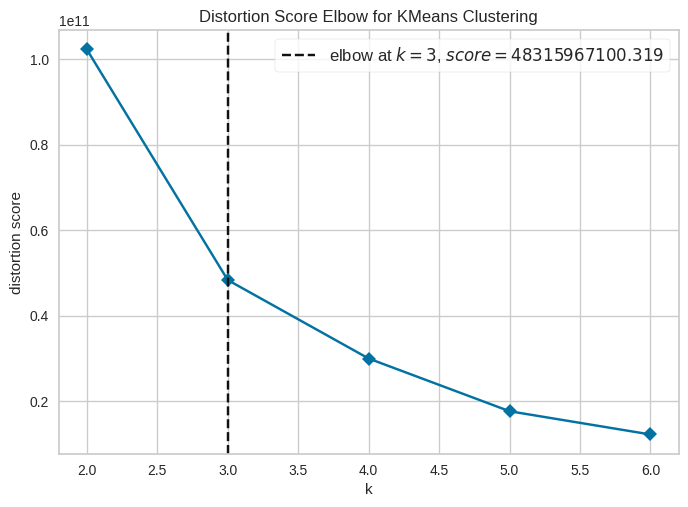

In [107]:
# number of cluster to test
clusters = [2, 3, 4, 5, 6]

# visualize WSS (Within-Cluster Sum of Square) metric 
kmeans = KElbowVisualizer(C.KMeans(), k=clusters, timings=False)
kmeans.fit(x)
kmeans.show();

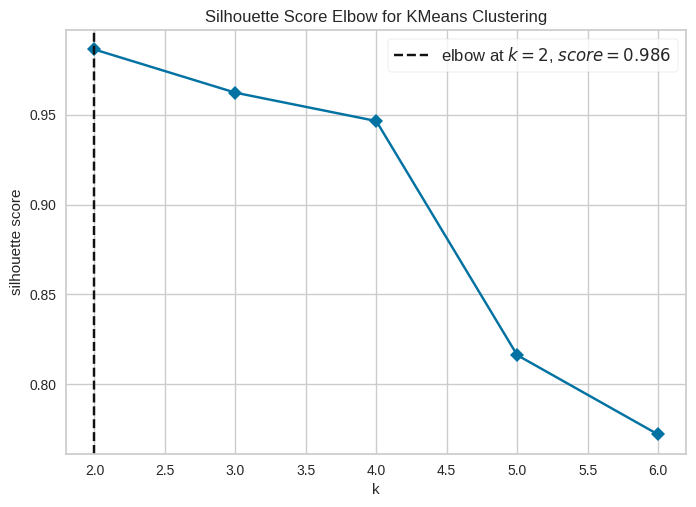

In [108]:
# visualize SS (Silhouette Score) metric 
kmeans = KElbowVisualizer(C.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(x)
kmeans.show();

# 9.0. MODEL TRAINING

## 9.1. K-Means

In [115]:
# model definition
k = 4
kmeans = C.KMeans(init='random', n_clusters=k, n_init=100, max_iter=300)

# model training
kmeans.fit(x)

# clustering
labels = kmeans.labels_

### 9.1.2. K-Means cluster validation

In [116]:
# WSS (Within-Cluster Sum of Square)
print('WSS value: {}'.format(kmeans.inertia_))

# SS (Silhouette Score)
print('SS value: {}'.format(M.silhouette_score(x, labels, metric='euclidean')))

WSS value: 40642181282.619545
SS value: 0.8172997193341269


# 10.0. CLUSTER ANALYSIS

In [117]:
df_ref_10 = df_ref_8.copy()
df_ref_10['clusters'] = labels

## 10.1. Visualization Inspection

In [118]:
fig = px.scatter_3d(df_ref_10, x='recency', y='frequency', z='gross_revenue', color='clusters')
fig.show()

## 10.2. Clusters Profile

In [119]:
# number of customer
df_cluster = df_ref_10[['customer_id', 'clusters']].groupby('clusters').count().reset_index().rename(columns={'customer_id':'qty_customers'})
df_cluster['perc_customer'] = 100*(df_cluster['qty_customers']/df_cluster['qty_customers'].sum())

# avg gross revenue
df_avg_gr = df_ref_10[['gross_revenue', 'clusters']].groupby('clusters').mean().reset_index().rename(columns={'gross_revenue':'avg_gross_revenue'})
df_cluster = pd.merge(df_cluster, df_avg_gr, on='clusters', how='left')

# avg recency days
df_avg_rd = df_ref_10[['recency', 'clusters']].groupby('clusters').mean().reset_index().rename(columns={'recency':'avg_recency'})
df_cluster = pd.merge(df_cluster, df_avg_rd, on='clusters', how='left')

# avg frequency
df_avg_fr = df_ref_10[['frequency', 'clusters']].groupby('clusters').mean().reset_index().rename(columns={'frequency':'avg_frequency'})
df_cluster = pd.merge(df_cluster, df_avg_fr, on='clusters', how='left')


In [120]:
df_cluster.head()

,clusters,qty_customers,perc_customer,avg_gross_revenue,avg_recency,avg_frequency
0,0,6,0.138440,182424.413333,8.166667,1728.000000
1,1,260,5.999077,8184.799115,22.600000,322.415385
2,2,28,0.646054,43307.133571,14.107143,1062.392857
3,3,4040,93.216428,954.305027,98.446535,64.278713


### 10.2.1. Cluster Insiders

- Cluster: 1
- Number of customers: 6 (0.14% of customer base)
- Average recency (days since last purchase): 8 days
- Average frequency (purchases in last 365 days): 1803 purchases
- Average gross revenue: $ 180,182.00

# 11.0. DEPLOY